c:\Users\decke\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


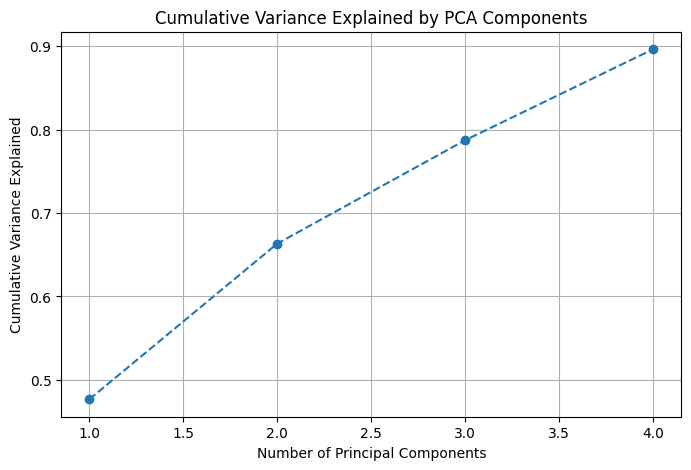

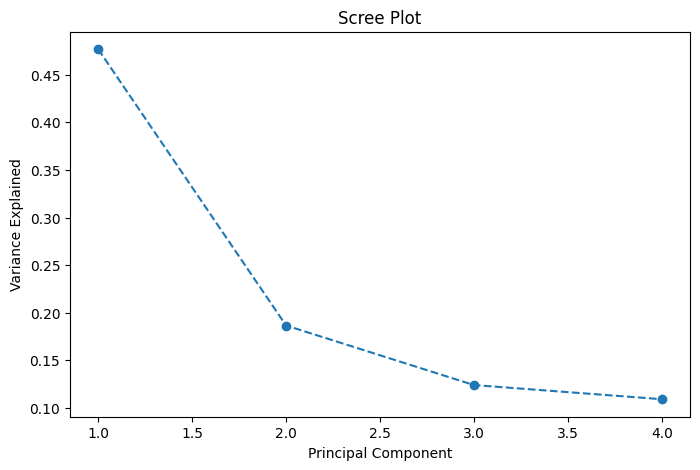

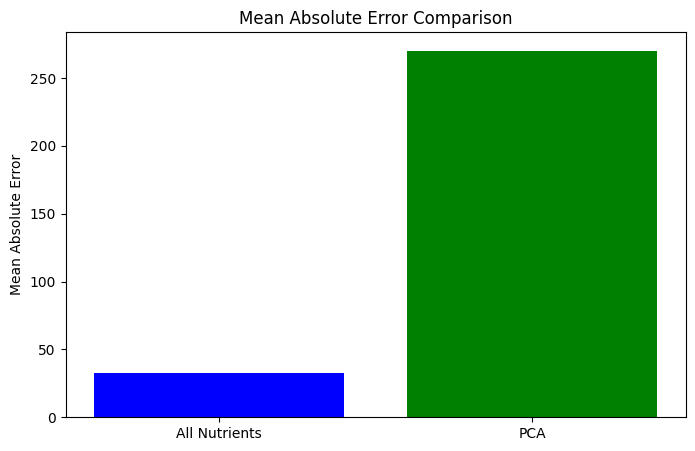

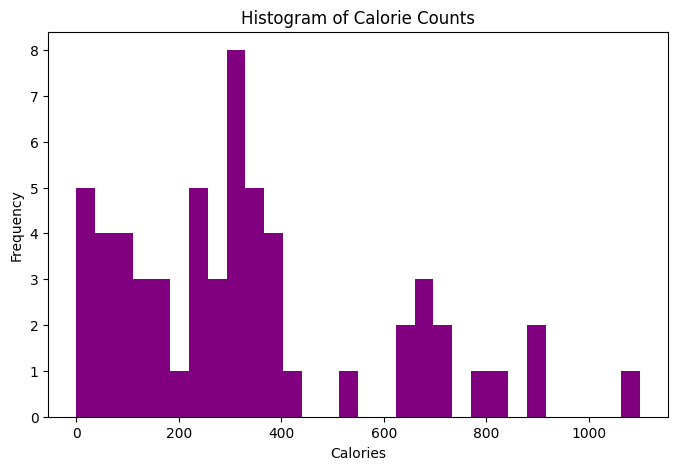

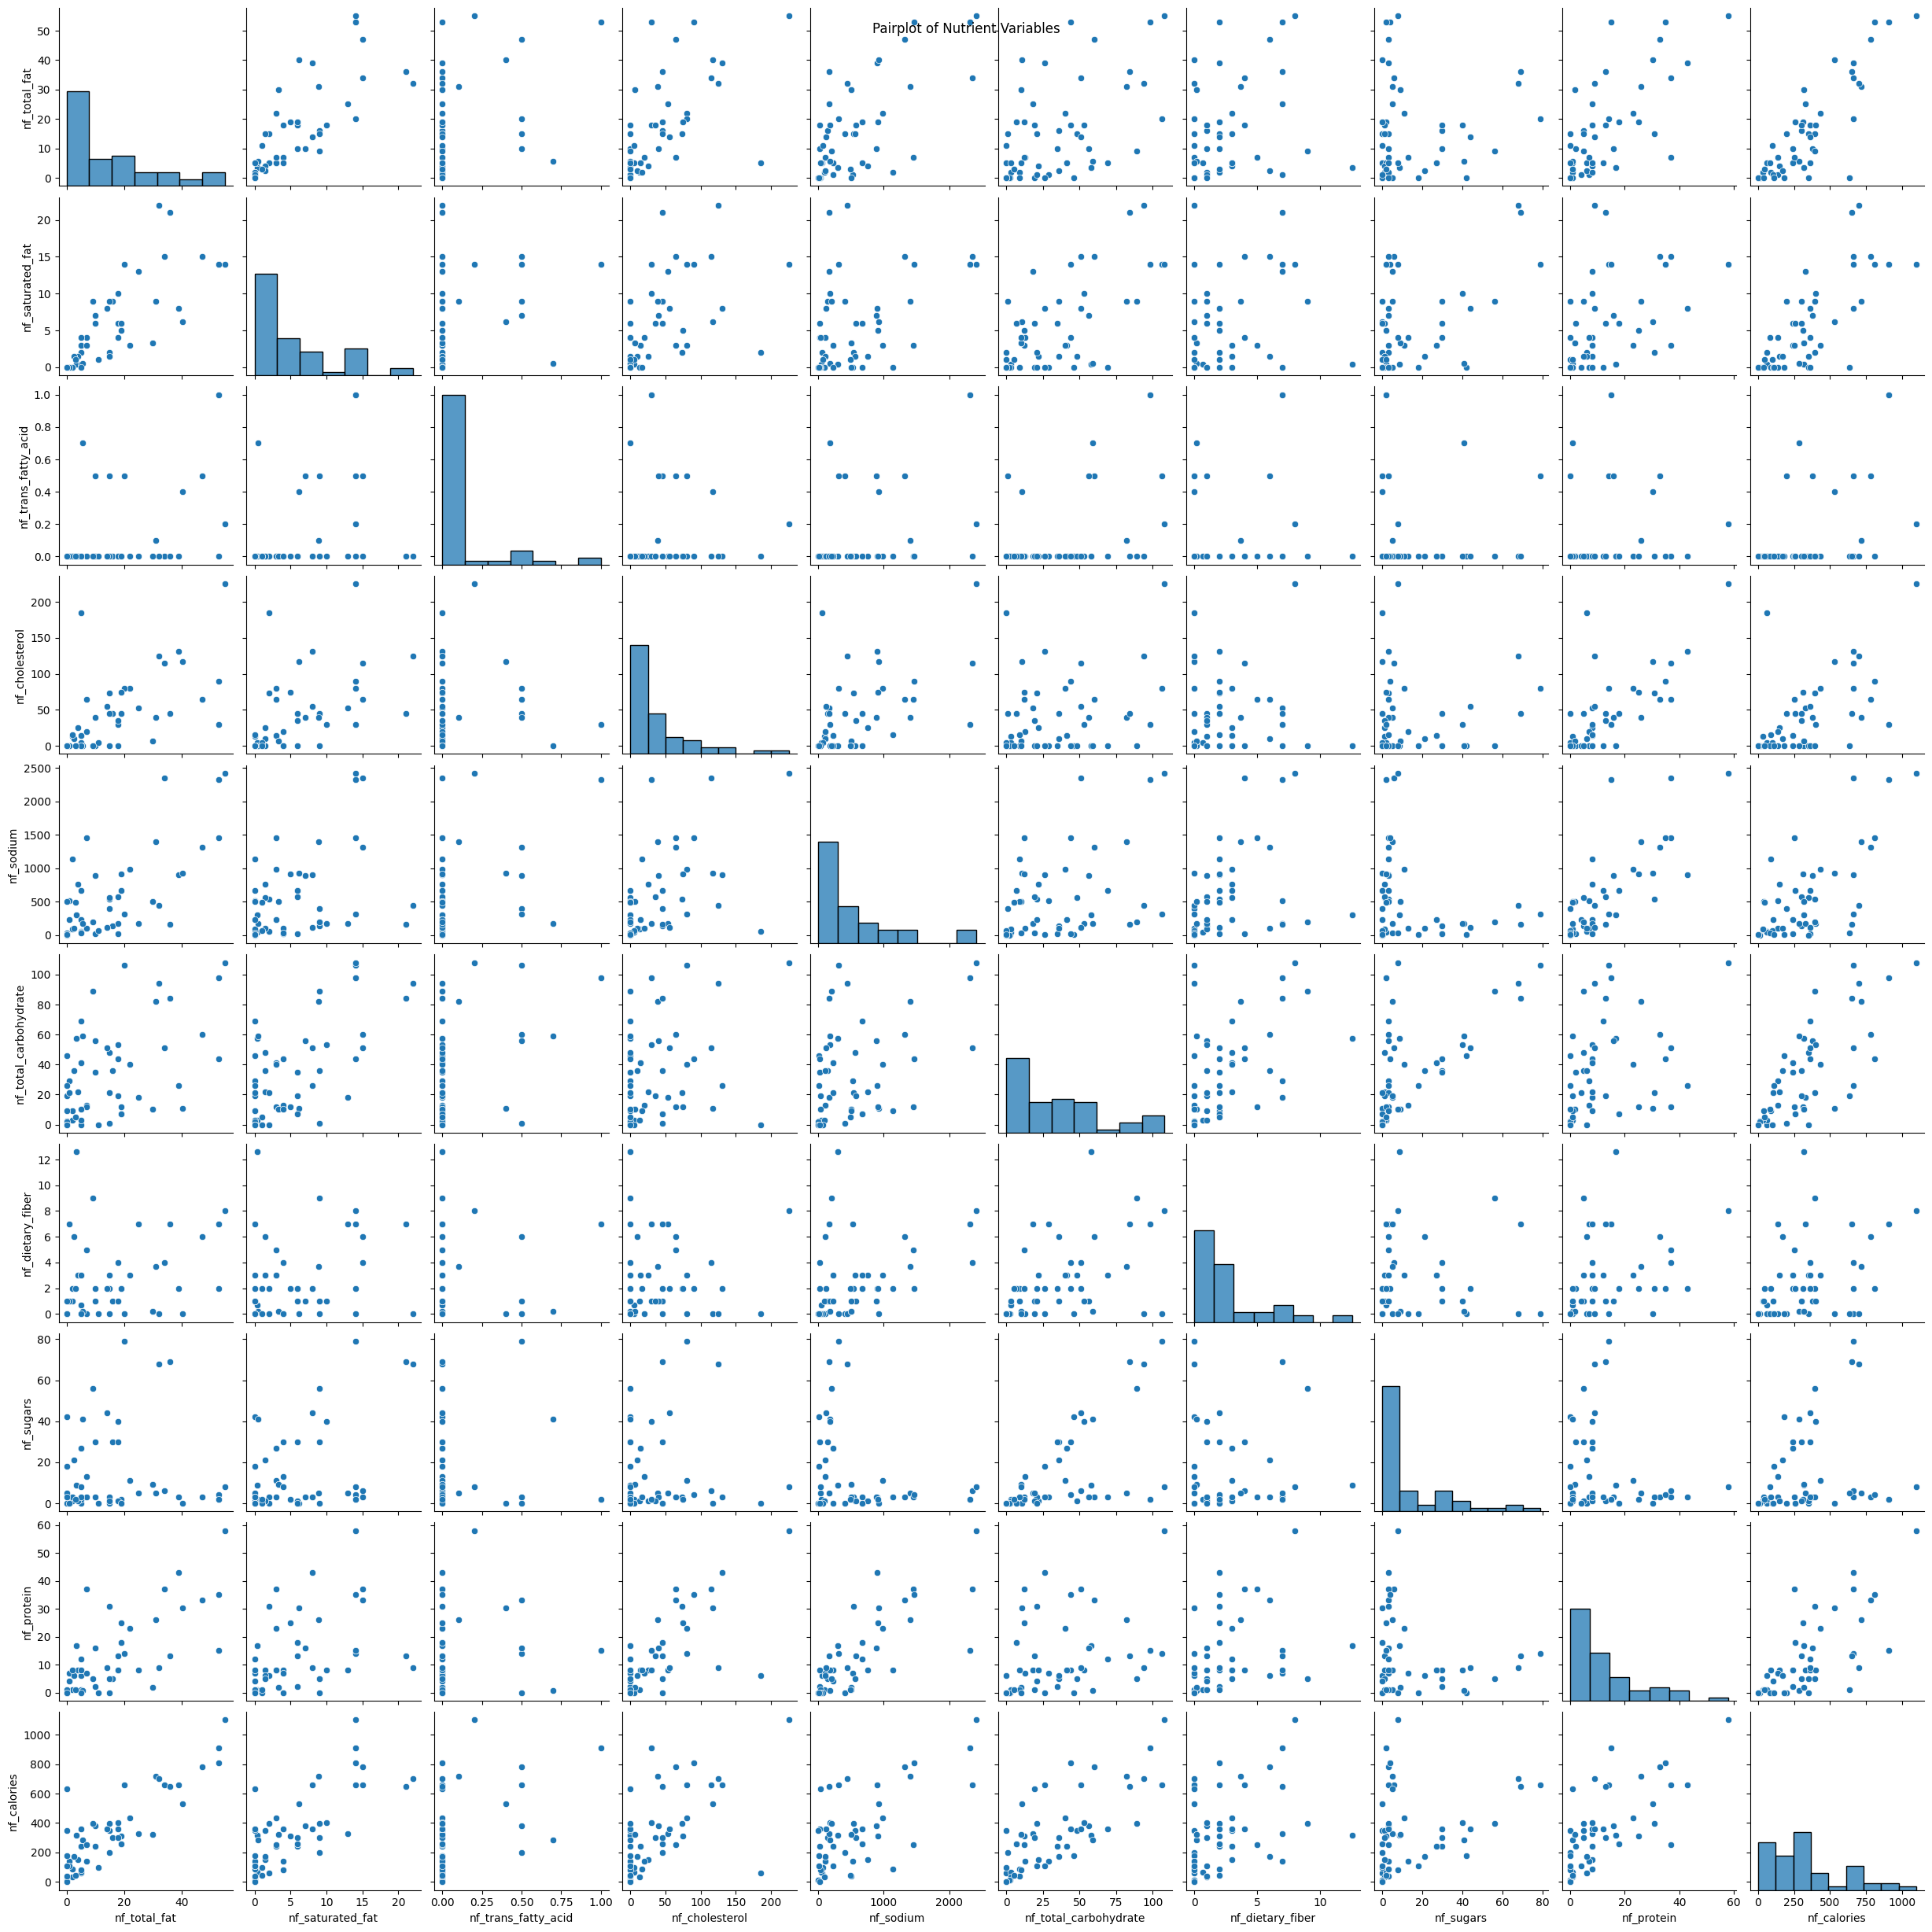

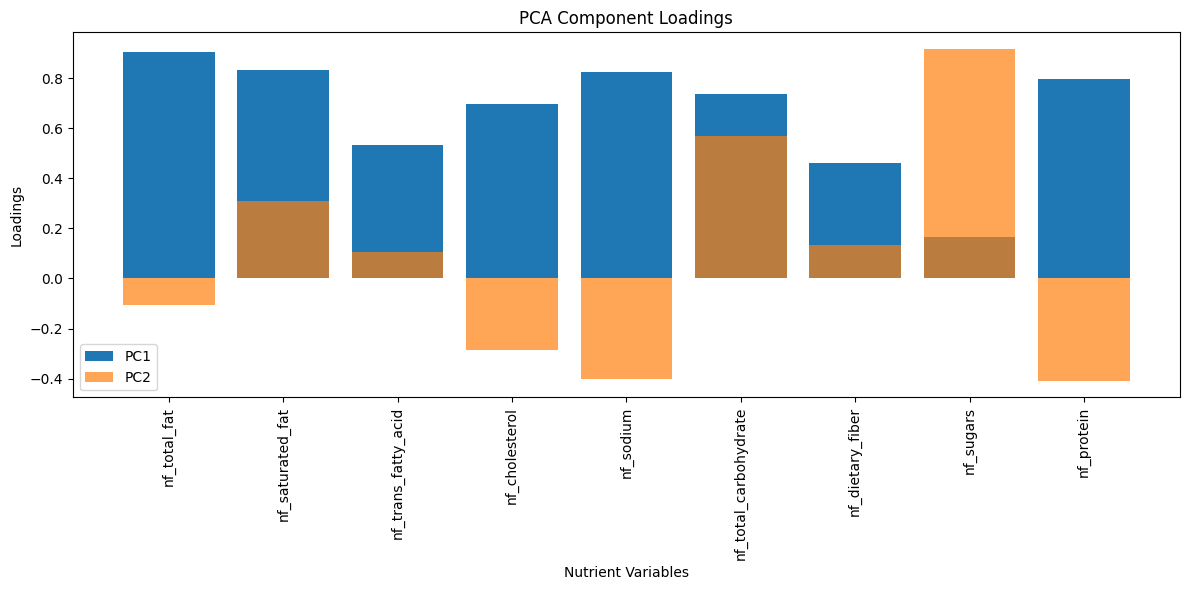

Mean Absolute Error (All Nutrients): 32.93801126874494
Mean Absolute Error (PCA): 270.1513750515998
p-value for the t-test: 0.001342328193966927


In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
# Import necessary libraries

# Read the CSV file and address missing values
data = pd.read_csv("C:/Users/decke/Downloads/restaurant_sample.csv")

# Drop rows with missing values in nutrient variables and calorie count
nutrient_columns = ["nf_total_fat", "nf_saturated_fat", "nf_trans_fatty_acid", "nf_cholesterol", "nf_sodium",
                    "nf_total_carbohydrate", "nf_dietary_fiber", "nf_sugars", "nf_protein"]

#below all_columns is for a pairplot graph
all_columns = ["nf_total_fat", "nf_saturated_fat", "nf_trans_fatty_acid", "nf_cholesterol", "nf_sodium",
                    "nf_total_carbohydrate", "nf_dietary_fiber", "nf_sugars", "nf_protein", "nf_calories"]
data = data.dropna(subset=nutrient_columns + ["nf_calories"])


# Handle outliers in nutrient variables and calorie count
z_scores = np.abs(stats.zscore(data[nutrient_columns + ["nf_calories"]]))
data = data[(z_scores < 3).all(axis=1)]

# Perform PCA on the nutrient variables to retain 90% of the variance
X = data[nutrient_columns]
y = data["nf_calories"]
#
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#found 4 componenets keep 89.9% of variance nearly 90 (good enough in this case)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)
X_test_pca = pca.transform(scaler.transform(X_test))
#Build linear regression models using all nutrient variables and PCA components
regression_model = LinearRegression()
pca_model = LinearRegression()

#fit
regression_model.fit(X_train, y_train)
pca_model.fit(X_train_pca, y_train)
#predict
y_pred_regression = regression_model.predict(X_test)
y_pred_pca = pca_model.predict(X_test_pca)




# Calculate mean absolute error for both models
mae_regression = mean_absolute_error(y_test, y_pred_regression)
mae_pca = mean_absolute_error(y_test_pca, y_pred_pca)

#Perform a statistical test to determine if the difference in MAE is statistically significant
t_stat, p_value = stats.ttest_rel(np.abs(y_test - y_pred_regression), np.abs(y_test - y_pred_pca))


# Plot cumulative variance
plt.figure(figsize=(8, 5))
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()
#Create a scree plot to visualize the variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#Create a bar chart to compare the MAE of the two models
plt.figure(figsize=(8, 5))
models = ['All Nutrients', 'PCA']
mae_values = [mae_regression, mae_pca]
plt.bar(models, mae_values, color=['blue', 'green'])
plt.title('Mean Absolute Error Comparison')
plt.ylabel('Mean Absolute Error')
plt.show()
#histogram
plt.figure(figsize=(8, 5))
plt.hist(data['nf_calories'], bins=30, color='purple')
plt.title('Histogram of Calorie Counts')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

#Pairplot for nutrient variables
sns.pairplot(data[all_columns])
plt.suptitle('Pairplot of Nutrient Variables')
plt.show()
#component loadings for pca 1 and 2
plt.figure(figsize=(12, 6))
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.bar(range(1, len(nutrient_columns) + 1), loadings[:, 0], align='center', label='PC1')
plt.bar(range(1, len(nutrient_columns) + 1), loadings[:, 1], align='center', label='PC2', alpha=0.7)
plt.xticks(range(1, len(nutrient_columns) + 1), nutrient_columns, rotation=90)
plt.ylabel('Loadings')
plt.xlabel('Nutrient Variables')
plt.title('PCA Component Loadings')
plt.legend()
plt.tight_layout()
plt.show()


# Step 10: Print results and compare MAE
print("Mean Absolute Error (All Nutrients):", mae_regression)
print("Mean Absolute Error (PCA):", mae_pca)
print("p-value for the t-test:", p_value)

